In [73]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from kaggle.api.kaggle_api_extended import KaggleApi
from sqlalchemy.orm import declarative_base, sessionmaker
from sqlalchemy import Column, Integer, String, Date, Float, create_engine, inspect, text

In [74]:
root_dir = os.getcwd()
db_dir = 'database'
db_name = 'dataset.db'
db_path = os.path.join(root_dir, db_dir, db_name)
db_url = f'sqlite:///{db_path}'

kaggle_data_set = 'eduardolicea/healthcare-dataset'

dataset_dir = 'dataset'
dataset_name = 'modified_healthcare_dataset.csv'
dataset_path = os.path.join(root_dir, dataset_dir, dataset_name)

separator = f"\n{'-'*100}\n"

In [75]:
Base = declarative_base()

class Gender(Base):
    __tablename__ = 'genders'
    id = Column(Integer, primary_key=True, autoincrement=True)
    Gender = Column(String)

class BloodType(Base):
    __tablename__ = 'blood_types'
    id = Column(Integer, primary_key=True, autoincrement=True)
    BloodType = Column(String)

class MedicalCondition(Base):
    __tablename__ = 'medical_conditions'
    id = Column(Integer, primary_key=True, autoincrement=True)
    MedicalCondition = Column(String)

class Doctor(Base):
    __tablename__ = 'doctors'
    id = Column(Integer, primary_key=True, autoincrement=True)
    Doctor = Column(String, unique=True)

class Hospital(Base):
    __tablename__ = 'hospitals'
    id = Column(Integer, primary_key=True, autoincrement=True)
    Hospital = Column(String)

class InsuranceProvider(Base):
    __tablename__ = 'insurance_providers'
    id = Column(Integer, primary_key=True, autoincrement=True)
    InsuranceProvider = Column(String)

class AdmissionType(Base):
    __tablename__ = 'admission_types'
    id = Column(Integer, primary_key=True, autoincrement=True)
    AdmissionType = Column(String)

class Medication(Base):
    __tablename__ = 'medications'
    id = Column(Integer, primary_key=True, autoincrement=True)
    Medication = Column(String)

class TestResults(Base):
    __tablename__ = 'test_results'
    id = Column(Integer, primary_key=True, autoincrement=True)
    TestResults = Column(String)


class Patient(Base):
    __tablename__ = 'patients'
    id = Column(Integer, primary_key=True)
    Name = Column(String)
    Age = Column(Integer)
    DateOfAdmission = Column(Date)
    BillingAmount = Column(Float)
    RoomNumber = Column(Integer)
    DischargeDate = Column(Date)
    LengthOfStay = Column(Integer)

class DataSet(Base):
    __tablename__ = 'dataset'
    id = Column(Integer, primary_key=True, autoincrement=True)
    Name = Column(String)
    Age = Column(Integer)
    Gender = Column(String)
    BloodType = Column(String)
    MedicalCondition = Column(String)
    DateOfAdmission = Column(Date)
    Doctor = Column(String)
    Hospital = Column(String)
    InsuranceProvider = Column(String)
    BillingAmount = Column(Float)
    RoomNumber = Column(Integer)
    AdmissionType = Column(String)
    DischargeDate = Column(Date)
    Medication = Column(String)
    TestResults = Column(String)
    LengthOfStay = Column(Integer)
#
class LabelEncodingDF(Base):
    __tablename__ = 'view_label_encoding_df'
    id = Column(Integer, primary_key=True)
    Name = Column(String)
    Age = Column(Integer)
    GenderID = Column(Integer)
    BloodTypeID = Column(Integer)
    MedicalConditionID = Column(Integer)
    DateOfAdmission = Column(Date)
    DoctorID = Column(Integer)
    HospitalID = Column(Integer)
    InsuranceProviderID = Column(Integer)
    BillingAmount = Column(Float)
    RoomNumber = Column(Integer)
    AdmissionTypeID = Column(String)
    DischargeDate = Column(Date)
    MedicationID = Column(Integer)
    TestResultID = Column(Integer)
    # LengthOfStay = Column(Integer)


In [76]:

class Visualization:
    def __init__(self, data_frame):
        self.df = data_frame
        self.def_size = (8,5)

    def line_plot(self, **qargs) -> None:
        """
        Линейный график
        Входные переменные данных; должны быть числовыми.
        Можно передавать данные напрямую или ссылаться на столбцы в данных.

        :param x: Входная переменная данных.
        :param y: Входная переменная данных.
        :param title: Название
        :param xlabel: Подпись оси X.
        :param ylabel: Подпись оси Y.
        """
        plt.figure(figsize=qargs.get('figsize', self.def_size))
        sns.lineplot(x=qargs.get('x'), y=qargs.get('y'))
        plt.title(qargs.get('title',''))
        plt.xlabel(qargs.get('xlabel',''))
        plt.ylabel(qargs.get('ylabel',''))
        plt.show()

    def count_plot(self, **qargs):
        """
        Столбчатая диаграмма

        :param qargs:
        :return:
        """
        plt.figure(figsize=qargs.get('figsize',self.def_size))

        sns.countplot(data=self.df,
                      x=qargs.get('x'),
                      palette=qargs.get('palette', 'colorblind'),
                      hue=self.df[qargs.get('hue')] if 'hue' in qargs else None
        )
        plt.title(qargs.get('title',''))
        plt.xlabel(qargs.get('xlabel',''))
        plt.ylabel(qargs.get('ylabel',''))
        plt.legend (qargs.get('legend',[]))
        plt.show()


    def hist_plot(self, **qargs):
        """
        Гистограмма
        :param qargs:
        :return:
        """
        plt.figure(figsize=qargs.get('figsize', self.def_size))

        sns.histplot(data=self.df,
                     x=qargs.get('x'),
                     y=qargs.get('y'),
                     kde=qargs.get('kde', False),
                     bins=qargs.get('bins',  'auto'),
                     palette=qargs.get('palette'),
                     hue=self.df[qargs.get('hue')] if 'hue' in qargs else None
        )
        plt.title(qargs.get('title',''))
        plt.xlabel(qargs.get('xlabel',''))
        plt.ylabel(qargs.get('ylabel',''))
        plt.legend (qargs.get('legend',[]))
        plt.show()


    def heatmap_plot(self, **qargs):
        """
        Тепловая карта

        :param qargs:
        :return:
        """
        fig, ax = plt.subplots(figsize=qargs.get('figsize', self.def_size))
        sns.heatmap(
                    data=qargs.get('data', None),
                    mask=qargs.get('mask', None),
                    cmap=qargs.get('cmap', None),
                    vmin=qargs.get('vmin', None),
                    vmax=qargs.get('vmax', None),
                    annot=True,
                    ax=ax,

        )
        plt.title(qargs.get('title',''))
        plt.xlabel(qargs.get('xlabel',''))
        plt.ylabel(qargs.get('ylabel',''))

        plt.show()

    def pie_plot(self, **qargs):
        """
        Тепловая карта

        :param qargs:
        :return:
        """
        data = qargs.get('data', None)
        plt.figure(figsize=qargs.get('figsize', self.def_size))
        plt.pie(data,
                labels=qargs.get('labels', None),
                radius=1.2,
                autopct=qargs.get('autopct'))
        plt.title(qargs.get('title',''))
        plt.legend(qargs.get('legend',''))
        plt.show()

    def scatter_plot(self, **qargs):
        """
        Диаграмма рассеивания

        :param qargs:
        :return:
        """
        plt.figure(figsize=qargs.get('figsize', self.def_size))

        sns.scatterplot(data=self.df,
                     x=qargs.get('x'),
                     y=qargs.get('y'),
                     palette=qargs.get('palette'),
                     hue=self.df[qargs.get('hue')] if 'hue' in qargs else None
                     )
        plt.title(qargs.get('title', ''))
        plt.xlabel(qargs.get('xlabel', ''))
        plt.ylabel(qargs.get('ylabel', ''))
        plt.legend(qargs.get('legend', []))
        plt.show()

    def box_plot(self, **qargs):
        plt.figure(figsize=qargs.get('figsize', self.def_size))
        plt.boxplot(self.df,
                    tick_labels=self.df.columns)
        plt.title(qargs.get('title', ''))
        plt.ylabel(qargs.get('ylabel', ''))
        plt.grid(True)
        plt.show()

In [77]:
def load_data_csv(file_path):
    """
    Загрузка данных из CSV файла.
    :param file_path: Путь к CSV файлу.
    :return: DataFrame с загруженными данными.
    """
    try:
        return pd.read_csv(file_path)
    except Exception as e:
        raise Exception(e)


In [78]:
def load_kaggle_data_set(dataset):
    """
    Загрузка датасета из kaggle.

    Важно: Необходимо предварительно получить API Token.
    Переместите файл kaggle.json в папку ~/.kaggle/ (для Linux и macOS)
    или в C:/Users/<Ваше_имя_пользователя>/.kaggle/ (для Windows).
    Если папка .kaggle не существует, создайте ее.
    :param dataset:
    :return:
    """

    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(dataset=dataset,
                               path='./dataset',
                               force=True,
                               unzip=True)              # Загрузка и распаковка

In [79]:
engine = create_engine(db_url, echo=False)
Session = sessionmaker(bind=engine)

In [80]:
def db_cerate():
    try:
        with Session()  as session:
            Base.metadata.create_all(engine)                # Создать базу данных (если она еще не существует)
            session.commit()
    except Exception as e:
        raise (f'Ошибка создания базы данных: {e}')

In [81]:
def add_all_from_dataset_to_table(df: pd.DataFrame,
                                  table_name : str,
                                  unique_columns : list = None):
    """
    Преобразование столбца датафрейма в таблицу с избавлением от дубликатов и присвоением каждому значению уникального индекса.
    Думаю, что это своеобразный Label Encoding.

    :param df: датафрейм
    :param table_name: имя таблицы в БД
    :param unique_columns: Имя колонки для преобразования
    :return:
    """
    with Session() as session:
        truncate_table = text(f'DELETE FROM {table_name}')
        session.execute(truncate_table)
        session.commit()

    inspector = inspect(engine)

    # Получить список столбцов из таблицы 'patients', исключая id, т.к. он автоинкриментный в таблице
    columns = [col['name'] for col in inspector.get_columns(table_name) if col['name']  != 'id']

    # Если передан лист имен столбцов в которых значения д.б. уникальными
    if unique_columns:
        # Фильтр DataFrame, оставляя только те столбцы, которые есть в таблице, и дополнительный фильтр по уникальным
        df_filtered = df[columns].drop_duplicates(unique_columns)
    else:
        # Фильтр DataFrame, оставляя только те столбцы, которые есть в таблице
        df_filtered = df[columns]
    # Запись DataFrame в таблицу
    df_filtered.to_sql(table_name, con=engine, if_exists='append', index=False)

In [82]:
def fill_db_tabes(df: pd.DataFrame):
    # Разнесу все признаки по таблицам и присвою им уникальные индексы (своеобразный Label Encoding)

    add_all_from_dataset_to_table(df, 'genders', ['Gender'])
    add_all_from_dataset_to_table(df, 'blood_types', ['BloodType'])
    add_all_from_dataset_to_table(df, 'medical_conditions', ['MedicalCondition'])
    add_all_from_dataset_to_table(df, 'doctors', ['Doctor'])
    add_all_from_dataset_to_table(df, 'hospitals', ['Hospital'])
    add_all_from_dataset_to_table(df, 'insurance_providers', ['InsuranceProvider'])
    add_all_from_dataset_to_table(df, 'admission_types', ['AdmissionType'])
    add_all_from_dataset_to_table(df, 'medications', ['Medication'])
    add_all_from_dataset_to_table(df, 'test_results', ['TestResults'])
    add_all_from_dataset_to_table(df, 'patients')
    add_all_from_dataset_to_table(df, 'dataset')

In [83]:
# Создам представление
def create_view():
    drop_view = """DROP VIEW IF EXISTS view_label_encoding_df"""
    drop_table = """DROP TABLE IF EXISTS view_label_encoding_df"""
    create_sql = """
    CREATE VIEW view_label_encoding_df AS
    SELECT dataset.id,
            dataset.Name,
            dataset.Age,
            genders.id AS GenderID,
            blood_types.id AS BloodTypeID,
            medical_conditions.id AS MedicalConditionID,
            dataset.DateOfAdmission,
            doctors.id AS DoctorID,
            hospitals.id AS HospitalID,
            insurance_providers.id AS InsuranceProviderID,
            dataset.BillingAmount,
            dataset.RoomNumber,
            admission_types.id AS AdmissionTypeID,
            dataset.DischargeDate,
            medications.id AS MedicationID,
            test_results.id AS TestResultID,
            dataset.LengthOfStay
    FROM dataset
    JOIN genders ON genders.Gender = dataset.Gender
    JOIN blood_types ON blood_types.BloodType = dataset.BloodType
    JOIN medical_conditions ON medical_conditions.MedicalCondition = dataset.MedicalCondition
    JOIN doctors ON doctors.Doctor = dataset.Doctor
    JOIN hospitals ON hospitals.Hospital = dataset.Hospital
    JOIN insurance_providers ON insurance_providers.InsuranceProvider = dataset.InsuranceProvider
    JOIN admission_types ON admission_types.AdmissionType = dataset.AdmissionType
    JOIN medications ON medications.Medication = dataset.Medication
    JOIN test_results ON test_results.TestResults = dataset.TestResults;
    """

    with engine.connect() as connection:
        try:
            connection.execute(text(drop_view))
        except:
            pass
        try:
            connection.execute(text(drop_table))
        except:
            pass
        try:
            connection.execute(text(create_sql))
        except Exception as e:
            print(e)
            raise (f'Ошибка создания представления: {str(e)}')


In [84]:
try:
    if not os.path.exists(dataset_path):
        # Загрузка файла датасета из kaggle если он не загружен
        load_kaggle_data_set(kaggle_data_set)
        # Загрузка файла в датафрейм
    df = load_data_csv(dataset_path)
except Exception as e:
    raise Exception (f'При выполнении произошла ошибка: {e}')

In [85]:
# Экспорт датасета в Exel если не был создан ранее
dataset_exel = os.path.join(root_dir, 'dataset.xlsx')
if not os.path.exists(dataset_exel):
    df.to_excel(dataset_exel, index=False)

In [86]:
# Информация о датафрейме (датасете)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
 15  Length of Stay      55500 non-null  int64  
dtypes: f

In [87]:
# Вывод информации о дубликатах
print(separator, 'Количество дублирующихся значений: ', df.duplicated().sum())


----------------------------------------------------------------------------------------------------
 Количество дублирующихся значений:  0


In [88]:
# Отсутствующие значения в столбцах датафрейма. Можно посмотреть и в информации, но так более наглядно.
print(separator, 'Отсутствующие значения:\n', df.isna().sum())


----------------------------------------------------------------------------------------------------
 Отсутствующие значения:
 Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
Length of Stay        0
dtype: int64


In [89]:
# Переименовать столбцы для дальнейшей работы
df.rename(columns={'Blood Type'         : 'BloodType',
                   'Medical Condition'  : 'MedicalCondition',
                   'Date of Admission'  : 'DateOfAdmission',
                   'Insurance Provider' : 'InsuranceProvider',
                   'Billing Amount'     : 'BillingAmount',
                   'Room Number'        : 'RoomNumber',
                   'Admission Type'     : 'AdmissionType',
                   'Discharge Date'     : 'DischargeDate',
                   'Test Results'       : 'TestResults',
                   'Length of Stay'     : 'LengthOfStay'
                   },
          inplace=True
)

In [90]:
# Работа с БД
db_cerate()         # Создать БД, со всеми таблицами (таблицы пустые)
fill_db_tabes(df)   # Заполнить таблицы в БД соответствующими данными из датасета (датафрейма)
create_view()       # Создать представление

In [91]:
def get_view_label_encoding_df():
    with Session() as session:
        results = session.query(LabelEncodingDF).all()
        label_encoding_df = pd.DataFrame([r.__dict__ for r in results])
        # Удалить лишние столбцы
        label_encoding_df = label_encoding_df.drop(columns=['_sa_instance_state',
                                                            'id',
                                                            'Name',
                                                            'RoomNumber',
                                                            'DateOfAdmission',
                                                            'DischargeDate'])
    return label_encoding_df

In [92]:
def correlation_visualization(df):
    """
    Визуализация корреляции параметров
    """
    corr = df.corr()
    mask = np.triu(np.ones_like(corr), k=0)

    Visualization(df).heatmap_plot(data = corr,
                                   title='Тепловая карта корреляции параметров',
                                   mask=mask,
                                   annot=True,
                                   cmap='viridis',
                                   vmin=-1,
                                   vmax=1,
                                   figsize = (20,15)
    )

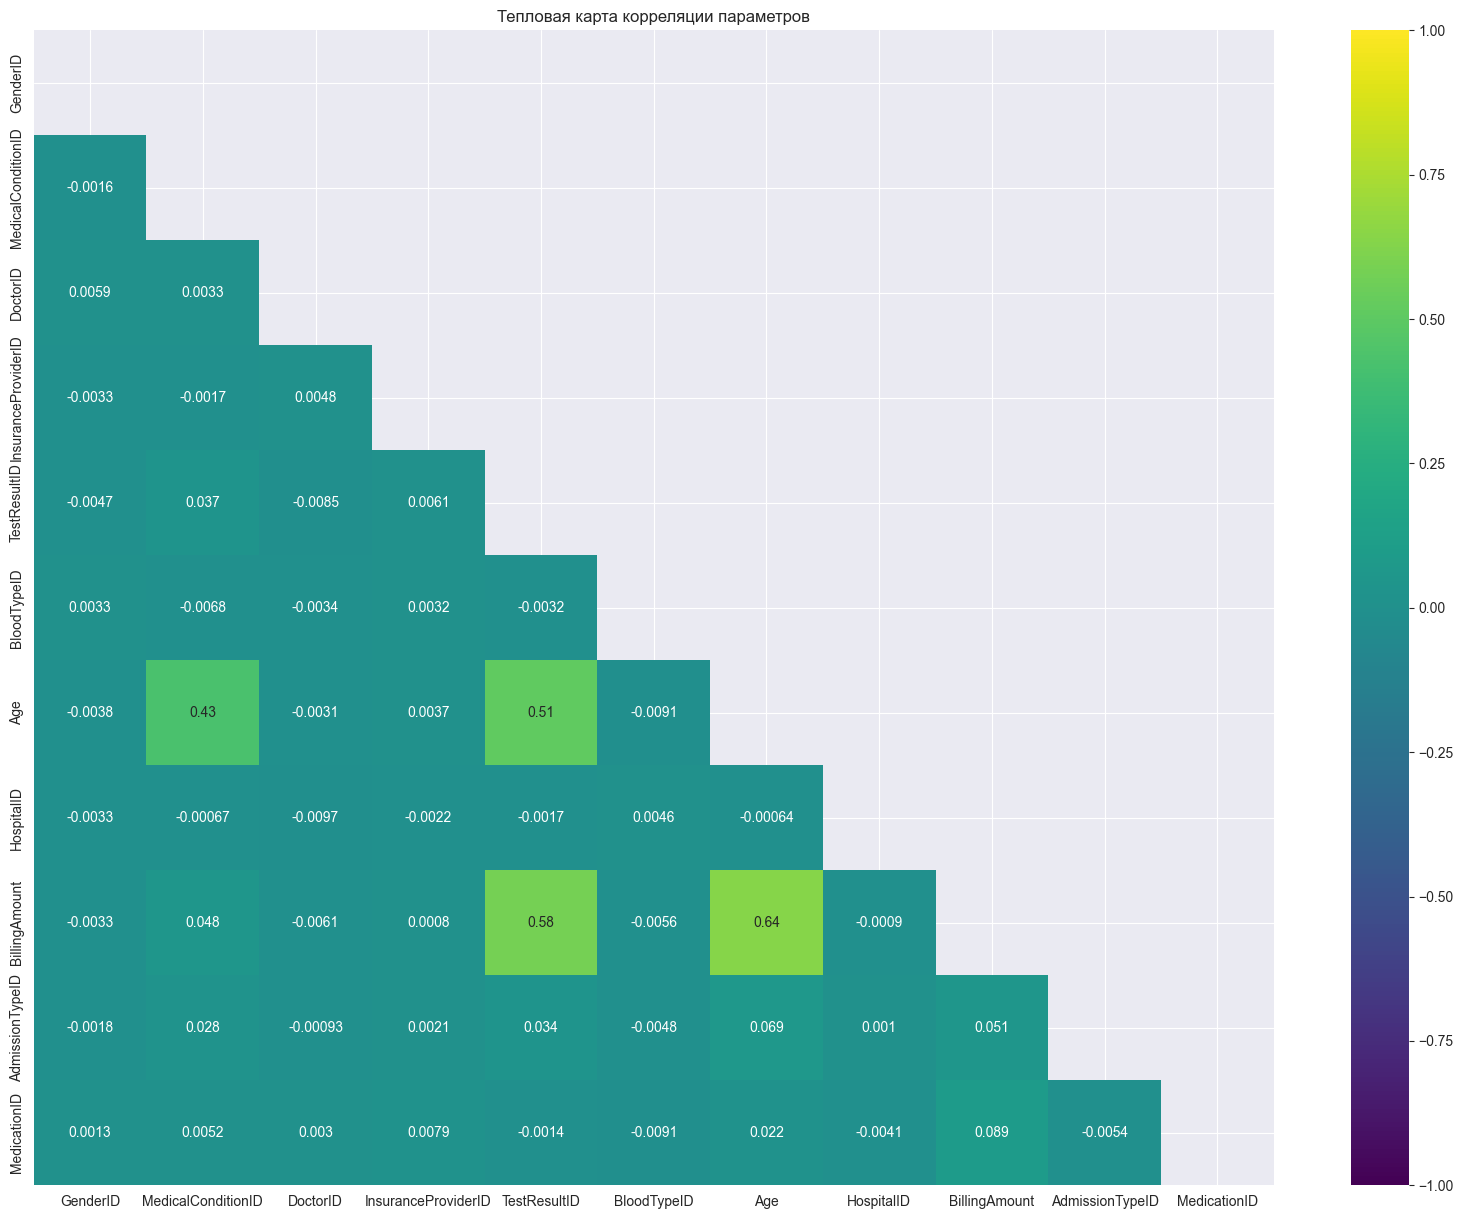

In [93]:
# Тепловая карта корреляции параметров
label_encoding_df = get_view_label_encoding_df()
correlation_visualization(label_encoding_df)

In [94]:
def bills_stat(df):
    """
    Визуализация количества распределения пациентов по клиникам
    """

    Visualization(df).hist_plot(x='BillingAmount',
                                # bins=10,
                                figsize=(20, 7),
                                title ='Распределение стоимости счетов за лечение.',
                                xlabel= 'Стоимость лечения',
                                ylabel = 'Количество пациентов',
                                )

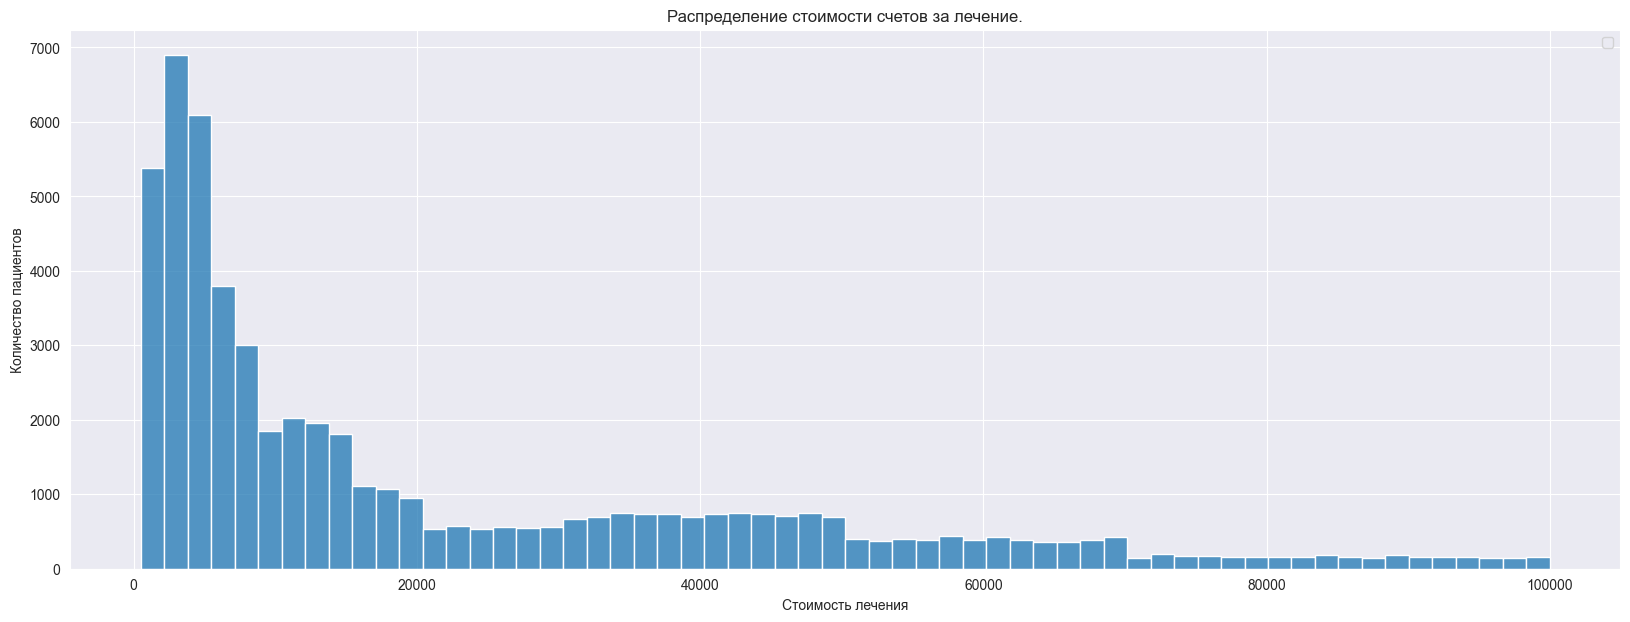

In [95]:
# Распределение стоимости счетов за лечение.
bills_stat(df)

In [96]:
# Создам запрос для получения стат данных по возрасту пациентов и стоимости лечения в зависимости от возраста
def sql_age_stat():
    sql = """
SELECT dataset.Age,
       COUNT(dataset.Age) AS PatientsCount,
       ROUND(MIN(dataset.BillingAmount),2) AS MinBill,
       ROUND(MAX(dataset.BillingAmount),2) AS MaxBill,
       ROUND(AVG(dataset.BillingAmount),2) AS AvgBill,
       ROUND(AVG(dataset.LengthOfStay),2) AS AvgLengthOfStay
FROM dataset
 GROUP BY dataset.Age;

    """

    with engine.connect() as connection:
        try:
            return connection.execute(text(sql))
        except Exception as e:
            raise (f'Ошибка создания представления: {e}')

In [97]:
age_stat = sql_age_stat()
df_age_stat = pd.DataFrame(age_stat)

In [98]:
def age_stst_visualization(df, field):
    Visualization(df).line_plot(title='График распределения количества пациентов по возрастному признаку',
                                y=df[field],
                                x=df['Age'],
                                figsize=(20, 7),
                                xlabel='Возрвст',
                                ylabel='Количество пациентов'
    )

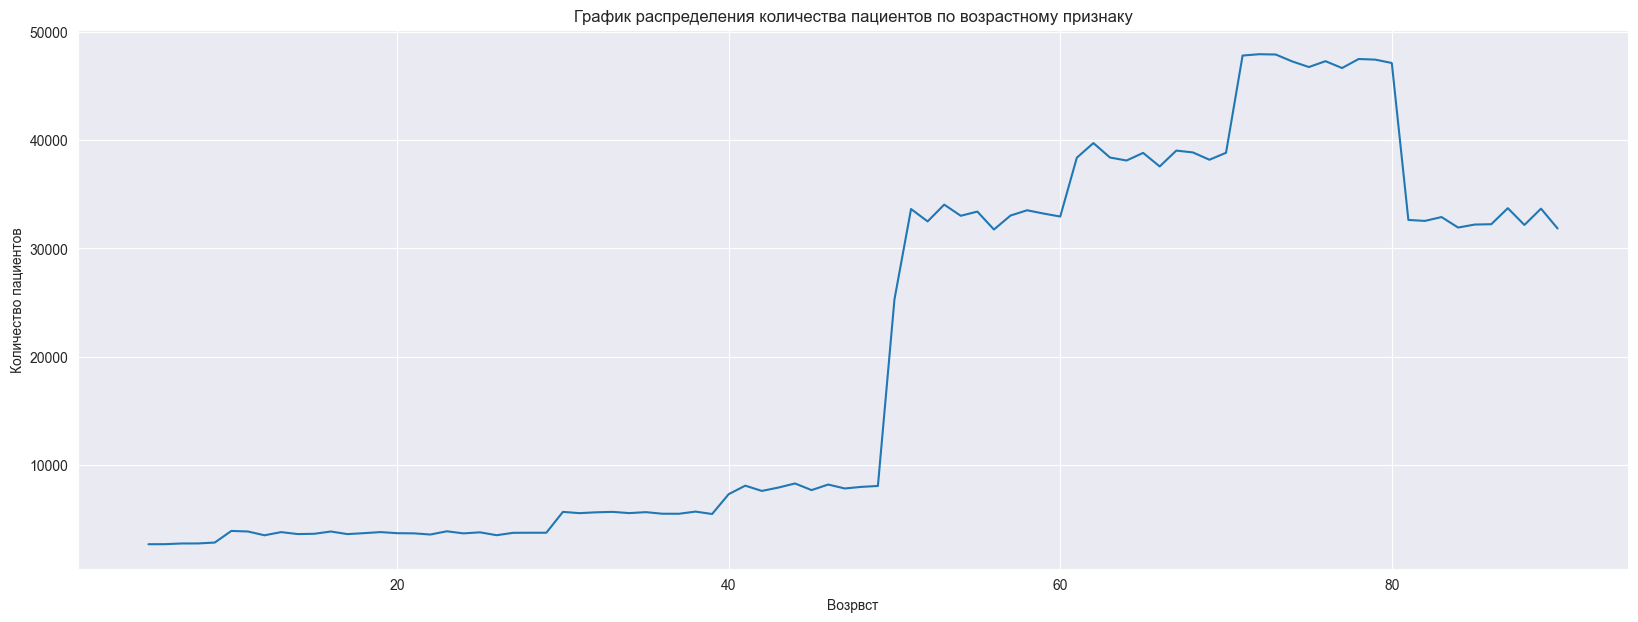

In [99]:
age_stst_visualization(df_age_stat, 'AvgBill')

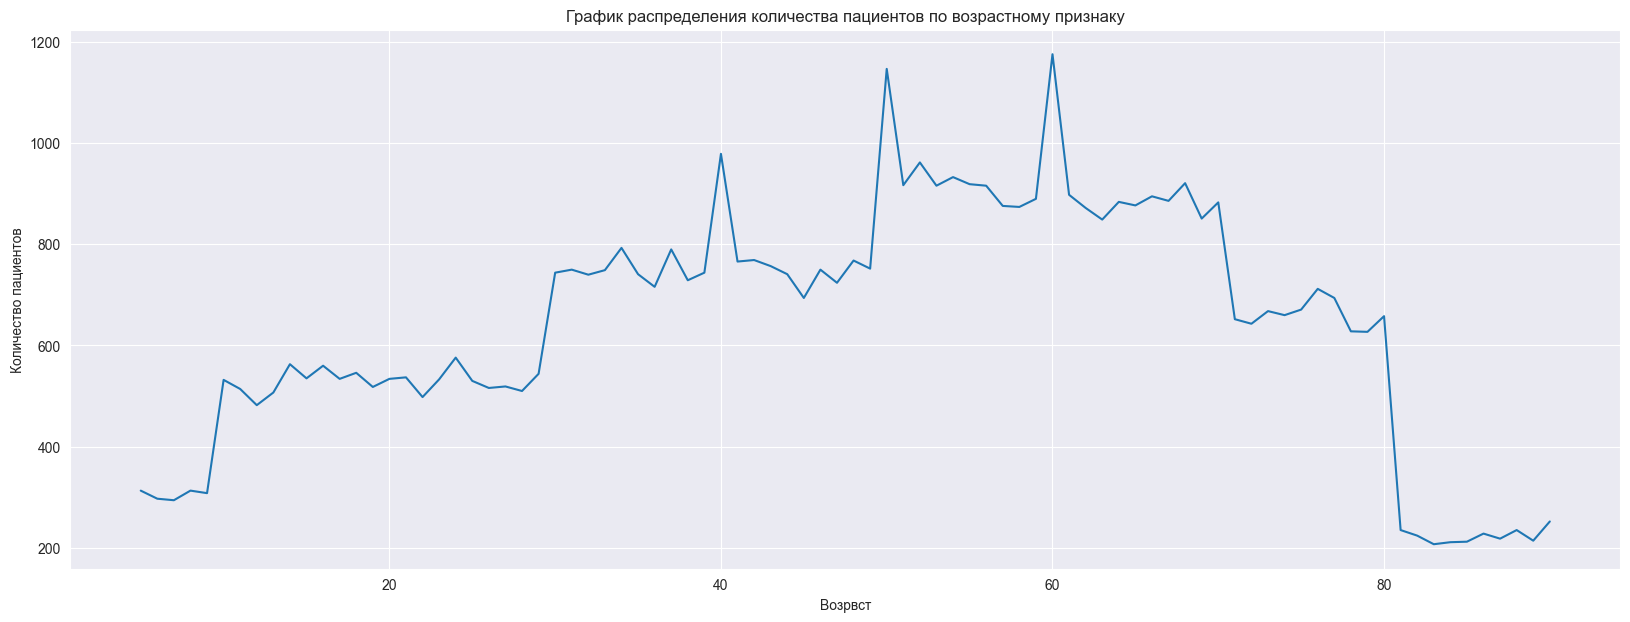

In [100]:
age_stst_visualization(df_age_stat, 'PatientsCount')

In [101]:
def medical_visualization(df):
        """
        Визуализаця рсредней продолжительности лечения в зависимисти от возраста пациента.

        :param df:
        :return:
        """
        # df_f = df[df['MEDICAL_UNIT'] == 7 & (df['AGE'] >= 30) & (df['AGE'] <= 60)]
        Visualization(df).scatter_plot(data=df,
                                         title='График средней продолжительности лечения в зависимисти от возраста пациента',
                                         y=df['AvgLengthOfStay'],
                                         x=df['Age'],
                                         figsize=(9,7),
                                         xlabel= 'Возраст',
                                         ylabel= 'Среднее количество дней'
        )

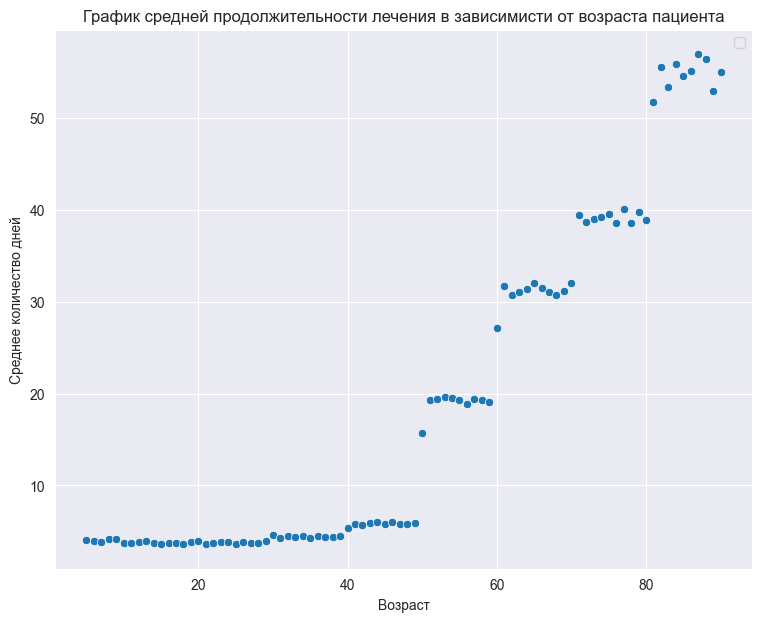

In [102]:
medical_visualization(df_age_stat)

In [103]:
def blood_type_visualization(df):
    """
    Визуализаця по группам крови и резус-факторам
    """
    data = df['BloodType'].value_counts()
    labels = list(df['BloodType'].value_counts().index)
    Visualization(df).pie_plot(data=data,
                               labels=labels,
                               title='Распределение пациентов по группам крови и резус-факторам',
                               autopct ='%1.1f%%',
                               figsize=(8,8)
    )

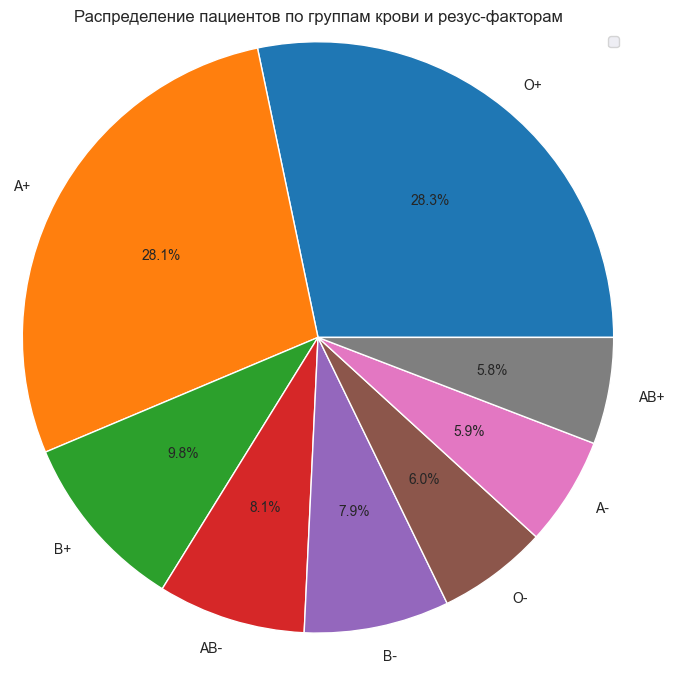

In [104]:
blood_type_visualization(df)

In [105]:
 # Создам запрос для получения стат данных по возрасту пациентов и стоимости лечения в зависимости от возраста
def sql_bills_by_medical_condition():

    sql = """
SELECT year_month,
       ROUND(SUM(CASE WHEN MedicalCondition = 'Alzheimer’s' THEN BillingAmount ELSE 0 END), 2) AS Альцгеймер,
       ROUND(SUM(CASE WHEN MedicalCondition = 'Asthma' THEN BillingAmount ELSE 0 END), 2) AS Астма,
       ROUND(SUM(CASE WHEN MedicalCondition = 'Cancer' THEN BillingAmount ELSE 0 END), 2) AS Рак,
       ROUND(SUM(CASE WHEN MedicalCondition = 'Diabetes' THEN BillingAmount ELSE 0 END), 2) AS Диабет,
       ROUND(SUM(CASE WHEN MedicalCondition = 'Flu' THEN BillingAmount ELSE 0 END), 2) AS Грипп,
       ROUND(SUM(CASE WHEN MedicalCondition = 'Heart Disease' THEN BillingAmount ELSE 0 END), 2) AS Болезни_сердца,
       ROUND(SUM(CASE WHEN MedicalCondition = 'Infections' THEN BillingAmount ELSE 0 END), 2) AS Инфекционные,
       ROUND(SUM(CASE WHEN MedicalCondition = 'Obesity' THEN BillingAmount ELSE 0 END), 2) AS Ожирение
  FROM (
           SELECT MedicalCondition,
                  ROUND(SUM(BillingAmount), 2) AS BillingAmount,
                  strftime('%Y-%m', DischargeDate) AS year_month
             FROM dataset
            GROUP BY MedicalCondition,
                     year_month
       )
 GROUP BY year_month;
    """

    with engine.connect() as connection:
        try:
            return connection.execute(text(sql))
        except Exception as e:
            raise (f'Ошибка создания представления: {e}')

In [106]:
sql_bills_by_medical_condition()
df_bills = pd.DataFrame(sql_bills_by_medical_condition())
df_bills = df_bills.drop(columns=['year_month'])

In [107]:
def hospital_profit_visualization(df):
    """
    Визуализация по стоимости лечения в зависимости от заболевания.
    """
    Visualization(df).box_plot(title='Доход медицинских заведений за лечение заболеваний по типам',
                               ylabel='Сумма дохода, полученная мед. учреждениями, за лечение заболевания',
                               figsize=(12,8)
    )

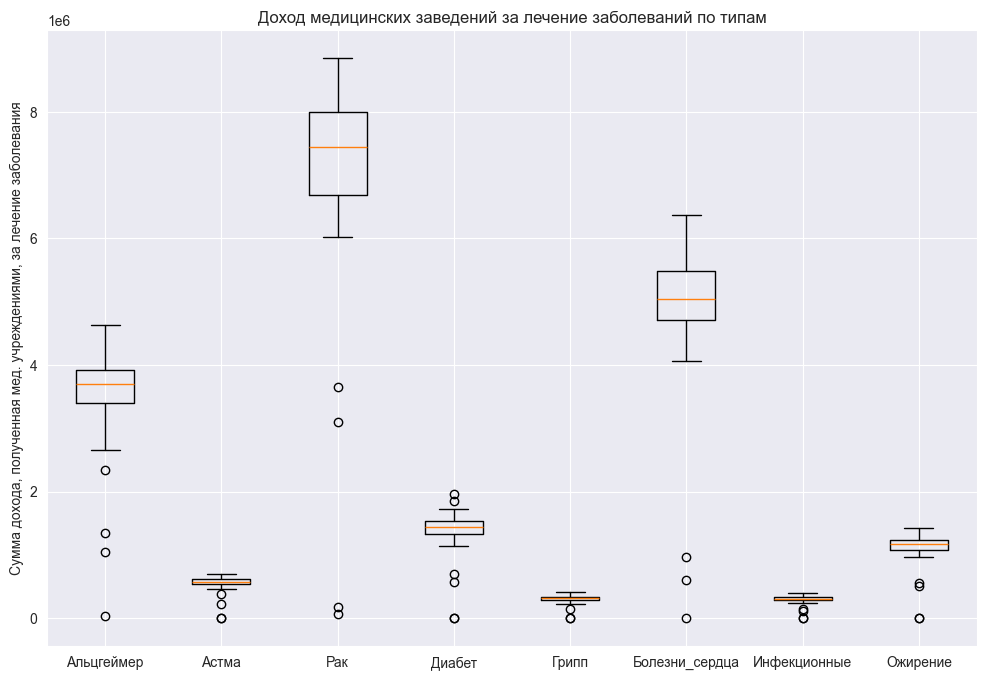

In [108]:
hospital_profit_visualization(df_bills)